In [3]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2


In [4]:
import os 
import sys
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
import osmnx as ox
%matplotlib qt

from buildings import *
from dem2stl import *

In [5]:
sys.path.append('..\\numpy2stl')
import numpy2stl as np2stl
from osm2stl import *

In [4]:
pd.set_option('display.max_rows', None)

In [4]:
%matplotlib qt

# Buildings and Cities: Philadelphia 

In [9]:
NSEW = np.array([39.967, 39.945,-75.135,-75.1925])
GEO_poly = ox.utils_geo.bbox_to_poly(*NSEW)
gdf = building_polygons(GEO_poly)

NameError: name 'building_polygons' is not defined

In [ ]:
poly = ox.geocode_to_gdf('Antwerp,Belgium')
poly2 = ox.project_gdf(poly)
GEO_poly = poly2.loc[0,"geometry"]

# Buildings and Cities: Antwerpen

In [1]:
from shapely.ops import cascaded_union
from shapely.geometry import Polygon,MultiPolygon
from shapely.geometry import polygon

def polygon_to_perimeter(poly):
    
    poly = polygon.orient(poly)
    
    verts,peri = [],[]
    n_v = 0
    exter = np.array(poly.exterior.coords)
    exter = exter[:-1]
    verts.extend(exter)
    peri.append( np.arange(len(exter) + n_v ))
    n_v = len(exter) + n_v 
    
    
    inter = poly.interiors
    for p in inter:
        pts = p.coords[:-1]
        verts.extend( pts )
        peri.append( np.arange(len(pts)) + n_v )
        n_v = len(pts) + n_v             
               
    verts = np.array(verts)
    
    perimeters = []
    for line_idx in peri:
        line = verts[line_idx]
        
        angles = get_perimeter_angles( line) 
        simpified_line = np.array(line_idx[  (angles < 179) | (angles > 181) ])
        perimeters.append(simpified_line)
    

    return verts,perimeters

def polygon_to_prism(polygons,heights,base_val=0):
    all_triangles = []

    for n,poly in enumerate(polygons):
        print(n)
        #if poly.area < 500: continue        
        
        verts, peri = polygon_to_perimeter(poly)
        verts = np.concatenate((verts, verts[:,0:1]*0),axis=1)
        
        verts[:,2] = heights[n]
        try:
            _, faces = np2stl.simplify_surface(verts, peri)
        except: 
            continue
        
        #    print(verts)
        ## Add Z value
        top_tris = verts[faces]
        all_triangles.append( top_tris )
        wall_tris = np2stl.perimeter_to_walls(verts, peri, floor_val=base_val)
        all_triangles.append( wall_tris )

    return all_triangles

def shapely_to_buildings(shp_poly, z0=1,z1=39,polygons=None):
    if polygons is None:
        polygons = []
        
    for poly in shp_poly:
        p = {}
        p['roof_height'] = z1
        p['base_height'] = z0
        p['points'] = np.array(poly.exterior.coords).T
        polygons.append(p)
        
    return polygons

def triangulate_buildings(polygons):

    triangles = []

    for _,p in enumerate( polygons ):

        roof = p['roof_height'] 
        base = p['base_height'] 
        vert = p['points'].T

        #if (np.isclose(vert[0],vert[-1])):   
        vert = vert[:-1]

        zdim = np.zeros((len(vert),1)) + roof
        vert = np.concatenate([vert, zdim],axis=1)
        
        tri = np2stl.polygon_to_prism(vert, base_val=base)
        triangles.append( tri )

    triangles = np.concatenate(triangles)   
    return triangles

def boundry_to_poly(GEO_poly):
    pts = np.array(GEO_poly.exterior.coords).T
    p = {"points":pts,"roof_height":0,"base_height":-30}
    polygons = [p]

    return polygons

def get_waterways( GEO ):
    
    ftpt = ox.footprints_from_polygon(GEO, footprint_type="natural")    
    
    x = ftpt[ftpt["natural"]=="water"]
    x = x.dropna(axis=1, how='all')
    x = x[["geometry","name","waterway","natural"]]
    areas = [i["geometry"].area*10000000 for n,i in x.iterrows()]
    x["areas"] = areas
    x = x[x["areas"]>1]
    
    polys = [ i["geometry"].intersection(GEO) for n,i in x.iterrows()]
    x["geometry"] = polys
    x = ox.project_gdf(x)
    return x 

In [49]:
#bounds,bbox = get_boundries_osmnx('Antwerp,Belgium')
NSEW = np.array([51.242, 51.202,  4.42,  4.36])
GEO_poly = ox.utils_geo.bbox_to_poly(*NSEW)

In [61]:
print("Adding Buildings")
gdf = building_to_gdf(GEO_poly)
gdf = ox.project_gdf(gdf)
print("Making Polygons")
#building_poly = get_polygons(gdf)
heights = building_heights(gdf)

Adding Buildings
Making Polygons


In [65]:
gdf

geometry  building:levels  \
48807007  POLYGON ((554885.516 4633385.490, 554887.881 4...                1   

          building:height  
48807007              3.9

In [62]:
building_poly = get_polygons(gdf)
building_poly = [Polygon(poly["points"].T) for poly in building_poly]
building_poly = MultiPolygon(building_poly)
building_poly = cascaded_union(building_poly)
print(building_poly)

POLYGON ((554885.5160831779 4633385.489728569, 554887.8811007196 4633389.927066341, 554891.6669920961 4633395.274716432, 554897.9901487712 4633391.31510581, 554891.8359105643 4633381.963116937, 554889.9695194066 4633382.848115399, 554885.5160831779 4633385.489728569))


In [63]:
building_poly = shapely_to_buildings(building_poly , z0=0,z1=40)
print(building_poly)

TypeError: 'Polygon' object is not iterable

In [56]:
import trimesh

tris = triangulate_buildings(building_poly)
vertices, faces = np2stl.vertices_to_index(tris)
mesh = trimesh.Trimesh(vertices,faces)
#mesh.export("Antwerpen_buildings.stl")

In [57]:
mesh.show()

KeyError: 'type'

## Get Waterways

In [28]:
gdf_rivers = get_waterways( GEO_poly )

In [29]:
polygons = get_polygons(gdf_rivers)

water_poly = [Polygon(poly["points"].T) for poly in polygons]
water_poly = MultiPolygon(water_poly)
water_poly = cascaded_union(water_poly)


In [31]:
patches = [PolygonPatch(poly) for poly in water_poly]
patches.extend([PolygonPatch(poly) for poly in water_poly])
draw_patches(patches)

In [84]:
pts = np.array([np.array(water_poly.bounds)[[0,0,2,2,0]],np.array(water_poly.bounds)[[1,3,3,1,1]]])
p = {"points":pts,"roof_height":300,"base_height":1}
base_dict = [p]

In [41]:
water_dict = shapely_to_buildings(water_poly, z0=-10,z1=1,polygons=None)

In [48]:
building_poly

[{'points': array([[ 4.36 ,  4.42 ,  4.42 ,  4.36 ,  4.36 ],
         [51.202, 51.202, 51.242, 51.242, 51.202]]),
  'roof_height': 1,
  'base_height': -30}]

In [90]:

tris = triangulate_buildings(water_dict)
vertices, faces = np2stl.vertices_to_index(tris)
river_mesh = trimesh.Trimesh(vertices,faces)
#river_mesh.export("Antwerpen_Rivers.stl")

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80?\t\xae\x11IX#\xadJ\x00\x00\x80?\x19\xae\x11IT#\xadJ\x00\x00\x80?.\xae\x11IS#\xadJ\x00\x00\x80?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x00\x00\x80?.\xae\x11IS#\xadJ\x00\x00\x80?G\xae\x11IT#\xadJ\x00\x00\x80?\t\xae\x11IX#\xadJ\x00\x00\x80?\x00\x00\x00\x00\x00\x80\x00\x00\x00\x80\x00\x00\x80?\t\xae\x11IX#\xadJ\x00\x00\x80?G\xae\x11IT#\xadJ\x00\x00\x80?\t\xae\x11I_#\xadJ\x00\x00\x80?\x00\x00\x00\x00\x00\x80\x00\x00\x00\x00\x00\x00\x80?\t\xae\x11I_#\xadJ\x00\x00\x80?\x8b\xae\x11I\\#\xadJ\x00\x00\x80?\x10\xaf\x11Is#\xadJ\x00\x00\x80?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80?\x8b\xae\x11I\\#\xadJ\x00\x00\

## Almanjano

In [60]:
#bounds,bbox = get_boundries_osmnx('Antwerp,Belgium')
NSEW = np.array([41.8537, 41.848, -2.3345, -2.3421])
GEO_poly = ox.utils_geo.bbox_to_poly(*NSEW)

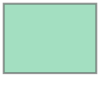

## Test

In [4]:
import numpy as np
m, heights = np.load("local.npy", allow_pickle=True)

In [5]:
np.save("local.npy", np.array([m,heights]))

NameError: name 'm' is not defined

In [18]:
tris = polygon_to_prism(m[150:155],heights,base_val=0)

0
1
2
3
4


In [37]:
np.concatenate(tris).shape

(111111, 3, 3)

In [27]:
tris

[array([[[5.97956373e+05, 5.67342433e+06, 3.90000000e+00],
         [5.97978857e+05, 5.67342564e+06, 3.90000000e+00],
         [5.97956544e+05, 5.67342450e+06, 3.90000000e+00]],
 
        [[5.97956373e+05, 5.67342433e+06, 3.90000000e+00],
         [5.97988468e+05, 5.67341489e+06, 3.90000000e+00],
         [5.97978857e+05, 5.67342564e+06, 3.90000000e+00]],
 
        [[5.97985488e+05, 5.67342202e+06, 3.90000000e+00],
         [5.97988468e+05, 5.67341489e+06, 3.90000000e+00],
         [5.97983163e+05, 5.67341969e+06, 3.90000000e+00]],
 
        ...,
 
        [[5.98081949e+05, 5.67355291e+06, 3.90000000e+00],
         [5.98079792e+05, 5.67355787e+06, 3.90000000e+00],
         [5.98079332e+05, 5.67355745e+06, 3.90000000e+00]],
 
        [[5.98072132e+05, 5.67357038e+06, 3.90000000e+00],
         [5.98089798e+05, 5.67357295e+06, 3.90000000e+00],
         [5.98070041e+05, 5.67357190e+06, 3.90000000e+00]],
 
        [[5.98064533e+05, 5.67353466e+06, 3.90000000e+00],
         [5.98074971e+05, 

In [26]:
patches = [PolygonPatch(poly) for poly in m]
draw_patches(patches,heights)

In [39]:
from skimage.measure import approximate_polygon

In [28]:
for p in m[150:152]:

    exter = np.array(p.exterior.coords)
    plt.plot(exter[:,0],exter[:,1],"-o")

    #inter = np.array(p.interiors)

In [22]:
sqr = np.array([[0,0],[1,0],[1,1],[0,1]])
poly = [sqr * 20 + 30, sqr*10 + 100, sqr] 
heights = [10,30,10]

m = [Polygon(p) for p in poly]
m = MultiPolygon(m)
m = cascaded_union(m)

In [38]:
for t in np.concatenate(tris[:100]):
    plt.plot(t[:,0],t[:,1])
    plt.plot(t[[-1,0],0],t[[-1,0],1])

In [36]:
tris

[array([[[5.97384610e+05, 5.67392895e+06, 3.90000000e+00],
         [5.97385183e+05, 5.67392969e+06, 3.90000000e+00],
         [5.97374565e+05, 5.67393764e+06, 3.90000000e+00]],
 
        [[5.97374565e+05, 5.67393764e+06, 3.90000000e+00],
         [5.97373984e+05, 5.67393696e+06, 3.90000000e+00],
         [5.97384610e+05, 5.67392895e+06, 3.90000000e+00]],
 
        [[5.97371496e+05, 5.67393954e+06, 3.90000000e+00],
         [5.97374565e+05, 5.67393764e+06, 3.90000000e+00],
         [5.97374905e+05, 5.67394294e+06, 3.90000000e+00]],
 
        [[5.97385183e+05, 5.67392969e+06, 3.90000000e+00],
         [5.97385629e+05, 5.67392974e+06, 3.90000000e+00],
         [5.97374565e+05, 5.67393764e+06, 3.90000000e+00]],
 
        [[5.97444238e+05, 5.67388609e+06, 3.90000000e+00],
         [5.97443493e+05, 5.67388521e+06, 3.90000000e+00],
         [5.97454084e+05, 5.67387724e+06, 3.90000000e+00]],
 
        [[5.97444238e+05, 5.67388609e+06, 3.90000000e+00],
         [5.97454084e+05, 5.67387724e+06,